<a href="https://colab.research.google.com/github/Abrx1921/Data-Science-Portfolio/blob/main/Decision_Trees_Project4_Spotify_V03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Music Popularity Prediction

by: Abraham Saenz Sigala

date: 10/28/2025

Version_03:

Basic Decsion Tree model with cross validation.

No feature engineering.

One Hot Encoding

Cross Validation and Hyperparameter Tuning (tree depth)

Dropped Features causing Data Leakage

# Loading in the Data

In [90]:
# Import initial libraries for data cleaning, manipulation, and exploration.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
# Load in the dataset
url = 'https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv'
url

'https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv'

In [92]:
# Read in the csv from our link
data = pd.read_csv(url)

In [93]:
# Ensure it loaded in correctly
data


,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,Release Date,Weeks Charted,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",2017-12-08,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,100,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],2021-07-09,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,99,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],2021-05-21,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,99,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",2021-06-25,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,98,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",2021-07-23,2021-07-23--2021-07-30,96,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,1552,195,1,2019-12-27--2020-01-03,New Rules,"4,630,675",Dua Lipa,27167675,2ekn2ttSfGqwhhate0LSR0,"['dance pop', 'pop', 'uk pop']",2017-06-02,2019-12-27--2020-01-03,79,0.762,0.7,-6.021,0.0694,0.00261,0.153,116.073,209320,0.608,A
1552,1553,196,1,2019-12-27--2020-01-03,Cheirosa - Ao Vivo,"4,623,030",Jorge & Mateus,15019109,2PWjKmjyTZeDpmOUa3a5da,"['sertanejo', 'sertanejo universitario']",2019-10-11,2019-12-27--2020-01-03,66,0.528,0.87,-3.123,0.0851,0.24,0.333,152.37,181930,0.714,B
1553,1554,197,1,2019-12-27--2020-01-03,Havana (feat. Young Thug),"4,620,876",Camila Cabello,22698747,1rfofaqEpACxVEHIZBJe6W,"['dance pop', 'electropop', 'pop', 'post-teen ...",2018-01-12,2019-12-27--2020-01-03,81,0.765,0.523,-4.333,0.03,0.184,0.132,104.988,217307,0.394,D
1554,1555,198,1,2019-12-27--2020-01-03,Surtada - Remix Brega Funk,"4,607,385","Dadá Boladão, Tati Zaqui, OIK",208630,5F8ffc8KWKNawllr5WsW0r,"['brega funk', 'funk carioca']",2019-09-25,2019-12-27--2020-01-03,60,0.832,0.55,-7.026,0.0587,0.249,0.182,154.064,152784,0.881,F


## Problem Definition


We aim to predict a song’s popularity score based on historical Spotify Top 200 Weekly data from 2020 and 2021. This is a supervised learning regression problem, where the goal is to minimize cross-validated RMSE when estimating the popularity of a new song using its available audio and metadata features.

# Data Dictionary

## 🎵 Spotify Top 200 (2020–2021) — Data Dictionary

| # | Column Name | Description | Units / Scale | Static or Weekly | Notes / Modeling Considerations |
|---|--------------|-------------|----------------|------------------|---------------------------------|
| 1 | **Index** | Sequential index of the dataset; a simple row number. | Integer | Static (per row) | Used for indexing only — drop before modeling. |
| 2 | **Highest Charting Position** | The best (lowest) chart rank achieved by the song across all weeks. | Integer (1–200) | Aggregated | Lower = better; may be correlated with popularity. |
| 3 | **Number of Times Charted** | Total number of weeks the song appeared on the Top 200 charts. | Integer | Aggregated | Indicates sustained popularity over time. |
| 4 | **Week of Highest Charting** | The chart week (date) during which the song reached its highest position. | Date (YYYY-MM-DD) | Weekly (time-specific) | Could be used for temporal analysis; convert to datetime. |
| 5 | **Song Name** | Title of the track. | Text | Static | Non-numeric; useful only for labeling, not modeling. |
| 6 | **Streams** | Number of Spotify streams for that chart week. | Integer | Weekly | Strong indicator of real-world popularity; may need log transform. |
| 7 | **Artist** | Name of the primary artist. | Text | Static | Non-numeric; may group by artist for aggregation or averaging. |
| 8 | **Artist Followers** | Total number of Spotify followers of the artist (at data collection time). | Integer | Static (snapshot) | Measures artist fame; can drive song popularity. |
| 9 | **Song ID** | Unique Spotify track identifier. | String | Static | Useful for merging with Spotify API data; drop in model. |
| 10 | **Genre** | Primary musical genre or subgenre of the track. | Categorical | Static | Requires one-hot encoding or grouping; may contain missing or multiple labels. |
| 11 | **Release Date** | Date the song was originally released. | Date (YYYY-MM-DD) | Static | Useful for feature engineering (e.g., “age of song” when charted). |
| 12 | **Weeks Charted** | Total number of distinct weeks the song appeared on the chart. | Integer | Aggregated | Correlates with long-term popularity. |
| 13 | **Popularity** | Spotify’s internal popularity score (0–100). Based on recent play counts and recency. | Integer (0–100) | Dynamic but snapshot | Usually the **target variable** for this project. |
| 14 | **Danceability** | How suitable a track is for dancing based on tempo, rhythm stability, beat strength, and overall regularity. | 0.0–1.0 | Static | Higher = more danceable. |
| 15 | **Energy** | Perceptual intensity and activity of a track (e.g., loud, fast, noisy). | 0.0–1.0 | Static | Correlated with loudness and tempo. |
| 16 | **Loudness** | Overall loudness of a track in decibels (dB). | Float (negative values) | Static | Typical range: –60 dB to 0 dB; higher (closer to 0) = louder. |
| 17 | **Speechiness** | Presence of spoken words in a track. | 0.0–1.0 | Static | > 0.66 = mostly speech (e.g., podcasts); < 0.33 = music. |
| 18 | **Acousticness** | Confidence measure of whether a track is acoustic. | 0.0–1.0 | Static | Higher = more acoustic. |
| 19 | **Liveness** | Likelihood the track was performed live. | 0.0–1.0 | Static | Higher (> 0.8) = live performance. |
| 20 | **Tempo** | Estimated tempo (beats per minute). | Float (BPM) | Static | Average tempo ≈ 120 BPM for pop. |
| 21 | **Duration (ms)** | Track length in milliseconds. | Integer | Static | Convert to minutes = `duration_ms / 60000`. |
| 22 | **Valence** | Musical positiveness — high = happy/cheerful, low = sad/tense. | 0.0–1.0 | Static | Often correlated with genre mood. |
| 23 | **Chord** | Musical key or chord label derived from track analysis. | Categorical / Text | Static | Sometimes extracted from `key` + `mode`; may indicate tonality. |


## Data Collection/Sources


#### Data Source:

The data is available on AWS S3 at: https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv



## Initial Exploratory Analysis

In [94]:
# Intital Data Exploration
data.sample(5)

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,Release Date,Weeks Charted,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
662,663,104,1,2020-12-18--2020-12-25,You Make It Feel Like Christmas (feat. Blake S...,"8,696,354",Gwen Stefani,4805333,2OQ6a4CfUeYskpTTgyawyJ,"['dance pop', 'hip pop', 'pop', 'post-teen pop...",2017-10-06,2020-12-18--2020-12-25,44,0.635,0.87,-4.291,0.04,0.0156,0.118,93.0,156773,0.912,D
336,337,4,37,2020-09-18--2020-09-25,Holy (feat. Chance The Rapper),"5,063,015",Justin Bieber,48504126,5u1n1kITHCxxp8twBcZxWy,"['canadian pop', 'pop', 'post-teen pop']",2020-09-18,2021-05-28--2021-06-04\n2021-05-21--2021-05-28...,81,0.673,0.704,-8.056,0.36,0.196,0.0898,86.919,212093,0.372,F#/Gb
569,570,47,25,2020-09-25--2020-10-02,Mi Cuarto,"4,873,380",Jerry Di,149682,6fmQjRuo7XvRFCK2qex5hQ,"['cubaton', 'dominican pop', 'pop venezolano',...",2020-04-03,2021-02-05--2021-02-12\n2021-01-29--2021-02-05...,76,0.854,0.525,-4.426,0.214,0.819,0.146,97.054,197587,0.63,C#/Db
73,74,74,8,2021-07-23--2021-07-30,Loco,"8,093,413","Justin Quiles, Chimbala, Zion & Lennox",2895789,6PDlkWmrq2ZKiUuFt2aQsH,"['latin', 'reggaeton', 'trap latino']",2021-05-13,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,87,0.77,0.899,-2.981,0.0494,0.222,0.0894,128.05,231604,0.851,G#/Ab
294,295,119,6,2021-05-14--2021-05-21,No Role Modelz,"4,904,401",J. Cole,14097410,62vpWI1CHwFy7tMIcSStl8,"['conscious hip hop', 'hip hop', 'north caroli...",2014-12-09,2021-06-18--2021-06-25\n2021-06-04--2021-06-11...,84,0.692,0.521,-8.465,0.33,0.301,0.0565,100.45,292987,0.463,A#/Bb


In [95]:
# Data info (Question: What columns need dtype change and encoding)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Energy  

In [96]:
# of rows/columns
data.shape

(1556, 23)

In [97]:
# Column names
data.columns

Index(['Index', 'Highest Charting Position', 'Number of Times Charted',
       'Week of Highest Charting', 'Song Name', 'Streams', 'Artist',
       'Artist Followers', 'Song ID', 'Genre', 'Release Date', 'Weeks Charted',
       'Popularity', 'Danceability', 'Energy', 'Loudness', 'Speechiness',
       'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)', 'Valence',
       'Chord'],
      dtype='object')

In [98]:
# Summary stats
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Index,1556.0,778.500000,449.322824,1.0,389.75,778.5,1167.25,1556.0
Highest Charting Position,1556.0,87.744216,58.147225,1.0,37.00,80.0,137.00,200.0
Number of Times Charted,1556.0,10.668380,16.360546,1.0,1.00,4.0,12.00,142.0


In [99]:
# Creating a mask so I can view the columns with null values
nullmask = data.isna().sum()
nullmask

,0
Index,0
Highest Charting Position,0
Number of Times Charted,0
Week of Highest Charting,0
Song Name,0
Streams,0
Artist,0
Artist Followers,0
Song ID,0
Genre,0


In [100]:
# Filtering columns with null values > 1
nullmask = nullmask[nullmask > 0].sort_values(ascending = False)
nullmask

,0


In [101]:
# Find the % of missing values in columns
nullpercent = ((nullmask / data.shape[0]) * 100).round(2).sort_values(ascending = False)
nullpercent

,0


In [102]:
# Creating a mask so I can view the rows with null values
rnullmask = data.isna().sum(axis = 1)
rnullmask

,0
0,0
1,0
2,0
3,0
4,0
...,...
1551,0
1552,0
1553,0
1554,0


In [103]:
# Filtering rows with null values > 1
rnullmask = rnullmask[rnullmask > 1].sort_values(ascending = False)
rnullmask

,0


In [104]:
# Find the % of missing values in columns
rnullpercent = ((rnullmask / data.shape[1]) * 100).round(2).sort_values(ascending = False)
rnullpercent

,0


#### Picking a Target Variable

In [105]:
data[["Index", "Song Name", 'Popularity', "Number of Times Charted"]]

,Index,Song Name,Popularity,Number of Times Charted
0,1,Beggin',100,8
1,2,STAY (with Justin Bieber),99,3
2,3,good 4 u,99,11
3,4,Bad Habits,98,5
4,5,INDUSTRY BABY (feat. Jack Harlow),96,1
...,...,...,...,...
1551,1552,New Rules,79,1
1552,1553,Cheirosa - Ao Vivo,66,1
1553,1554,Havana (feat. Young Thug),81,1
1554,1555,Surtada - Remix Brega Funk,60,1


The built-in popularity score in Spotify data is a snapshot metric — it reflects Spotify’s own internal score (stream count, recency, etc.) at one point in time.

By contrast, “number of times charted” captures consistency and longevity — a song that appears on the Top 200 for 20 weeks clearly has enduring popularity versus one that spikes for a single week.

In [106]:
# Identify if there are any null values in our target variable (Two Options: Popularity or Number of Times Charted)
data["Number of Times Charted"].isna().sum()


np.int64(0)

In [107]:
# See if there are any blanks (nulls) in the data
data = data.apply(lambda col: col.map(lambda x: x.strip() if isinstance(x, str) else x))

What it does:

1. apply()

Runs a function on each column in the DataFrame (one column at a time).

Inside the parentheses, col represents a single column (a pandas Series).

2. col.map()

Applies a function to every value in that column.

3. lambda x: x.strip() if isinstance(x, str) else x

Checks if each cell’s value x is a string:

If yes → apply .strip() to remove spaces before and after the text.

If not (e.g., number, NaN, date) → leave it as-is.

In [108]:
(data.isna() | (data == '')).sum()

,0
Index,0
Highest Charting Position,0
Number of Times Charted,0
Week of Highest Charting,0
Song Name,0
Streams,0
Artist,0
Artist Followers,11
Song ID,11
Genre,11


What it does:

data.isna() → finds all real missing values (NaN).

(data == '') → finds all empty strings (after stripping).

| → means OR, so it combines both conditions.

.sum() → counts how many True values (missing or empty) appear per column.

In [109]:
# Creating correlation
corr = data.corr(numeric_only=True).round(2)
corr

,Index,Highest Charting Position,Number of Times Charted
Index,1.00,0.25,-0.36
Highest Charting Position,0.25,1.00,-0.42
Number of Times Charted,-0.36,-0.42,1.00


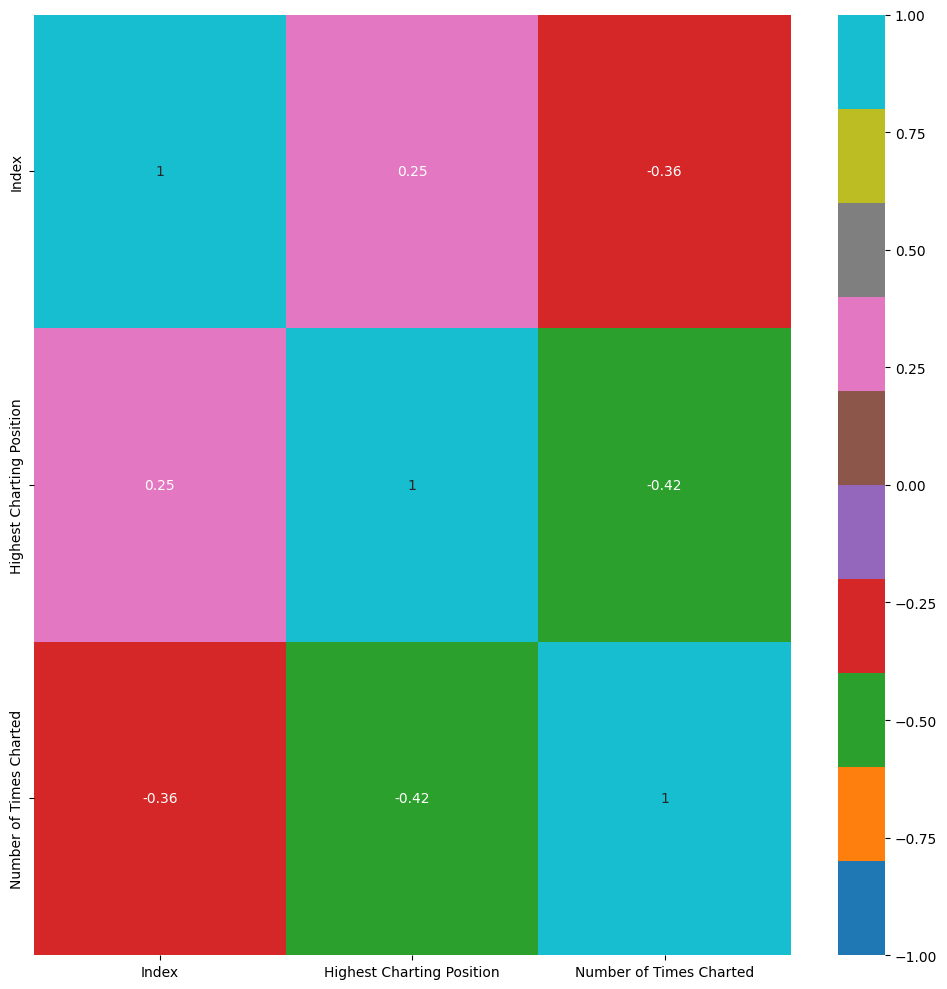

In [110]:
# Identifity non independent features and features correlated with target
plt.figure(figsize = (10, 10))
sns.heatmap(corr, vmin = -1, vmax = 1, cmap = 'tab10', annot = True)
plt.tight_layout()
plt.show()

In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Energy  

In [112]:
# Pick a random feature that will need one hot encoding to see the differnt value counts.
data['Genre'].value_counts()

,count
Genre,
[],75
"['dance pop', 'pop', 'post-teen pop']",71
"['latin', 'reggaeton', 'trap latino']",63
"['pop', 'post-teen pop']",57
"['melodic rap', 'philly rap', 'rap', 'trap']",33
...,...
"['basshall', 'turkish trap']",1
"['dance pop', 'edm', 'electro house', 'pop', 'pop dance', 'pop edm', 'tropical house']",1
"['dance pop', 'edm', 'pop', 'pop dance', 'post-teen pop', 'tropical house', 'uk pop']",1


In [113]:
import ast

# Convert list-like strings into actual Python lists
data['Genre'] = data['Genre'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else []
)

# Flatten (explode) all genres into one long column
all_genres = data.explode('Genre')['Genre']

# View unique genres and counts
genre_counts = all_genres.value_counts()

print(genre_counts)

Genre
pop                    485
rap                    310
dance pop              257
post-teen pop          256
pop rap                164
                      ... 
west coast rap           1
jazz funk                1
new orleans rap          1
deep german hip hop      1
turkish trap             1
Name: count, Length: 334, dtype: int64


Based on this, I beleive I am just going to drop this column... Its too complicated to deal with.

In [114]:
data['Chord'].value_counts()

,count
Chord,
C#/Db,214
C,155
B,141
G,136
F,131
G#/Ab,130
D,125
A#/Bb,122
F#/Gb,121


Things to do:

  - Convert all features to their appropriate data types.
  - Clean all instances where there are blanks " " in the data.
    - We found if there are any, so now we will replace blanks with NaN
  - Drop features which are identifiers
  - Perfrom One-Hot Encoding on neccassary features. (Won't do this for first pass)
  - Drop features that are also too complicated to work with. ("Genre")

## Data Cleaning


In [115]:
# Begin by creating a copy of the data
df = data.copy()
df

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,Release Date,Weeks Charted,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"[indie rock italiano, italian pop]",2017-12-08,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,100,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,[australian hip hop],2021-07-09,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,99,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,[pop],2021-05-21,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,99,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"[pop, uk pop]",2021-06-25,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,98,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"[lgbtq+ hip hop, pop rap]",2021-07-23,2021-07-23--2021-07-30,96,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,1552,195,1,2019-12-27--2020-01-03,New Rules,"4,630,675",Dua Lipa,27167675,2ekn2ttSfGqwhhate0LSR0,"[dance pop, pop, uk pop]",2017-06-02,2019-12-27--2020-01-03,79,0.762,0.7,-6.021,0.0694,0.00261,0.153,116.073,209320,0.608,A
1552,1553,196,1,2019-12-27--2020-01-03,Cheirosa - Ao Vivo,"4,623,030",Jorge & Mateus,15019109,2PWjKmjyTZeDpmOUa3a5da,"[sertanejo, sertanejo universitario]",2019-10-11,2019-12-27--2020-01-03,66,0.528,0.87,-3.123,0.0851,0.24,0.333,152.37,181930,0.714,B
1553,1554,197,1,2019-12-27--2020-01-03,Havana (feat. Young Thug),"4,620,876",Camila Cabello,22698747,1rfofaqEpACxVEHIZBJe6W,"[dance pop, electropop, pop, post-teen pop]",2018-01-12,2019-12-27--2020-01-03,81,0.765,0.523,-4.333,0.03,0.184,0.132,104.988,217307,0.394,D
1554,1555,198,1,2019-12-27--2020-01-03,Surtada - Remix Brega Funk,"4,607,385","Dadá Boladão, Tati Zaqui, OIK",208630,5F8ffc8KWKNawllr5WsW0r,"[brega funk, funk carioca]",2019-09-25,2019-12-27--2020-01-03,60,0.832,0.55,-7.026,0.0587,0.249,0.182,154.064,152784,0.881,F


In [116]:
# See instances of '' again
(df.isna() | (df == '')).sum()

,0
Index,0
Highest Charting Position,0
Number of Times Charted,0
Week of Highest Charting,0
Song Name,0
Streams,0
Artist,0
Artist Followers,11
Song ID,11
Genre,0


In [117]:
# Replace '' with nan
df = df.replace('', np.nan)

In [118]:
# Confirm this action for na's
df.isna().sum()

,0
Index,0
Highest Charting Position,0
Number of Times Charted,0
Week of Highest Charting,0
Song Name,0
Streams,0
Artist,0
Artist Followers,11
Song ID,11
Genre,0


In [119]:
# Confirm this action for ''
(df == '').sum()

,0
Index,0
Highest Charting Position,0
Number of Times Charted,0
Week of Highest Charting,0
Song Name,0
Streams,0
Artist,0
Artist Followers,0
Song ID,0
Genre,0


In [120]:
# Drop N/A's
df = df.dropna()

In [121]:
df.isna().sum().sum()

np.int64(0)

In [122]:
df.columns

Index(['Index', 'Highest Charting Position', 'Number of Times Charted',
       'Week of Highest Charting', 'Song Name', 'Streams', 'Artist',
       'Artist Followers', 'Song ID', 'Genre', 'Release Date', 'Weeks Charted',
       'Popularity', 'Danceability', 'Energy', 'Loudness', 'Speechiness',
       'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)', 'Valence',
       'Chord'],
      dtype='object')

In [123]:
# Drop N/A in Target Variable (No need, just safe)
df = df.dropna(subset = ["Number of Times Charted"])

In [124]:
# Dropping columns
df = df.drop(columns = ['Index', 'Song ID', 'Genre', 'Song Name', 'Artist'])
df.shape

(1545, 18)

Dropping index / song id. I also decided to drop genre (too hard to deal with rn). Dropped song name because I see it as an identifier as well. Many different artists in the data. Could use anova and onehot to see which ones have the best results dirrectly with the target but decided to drop for now.

In [125]:
pd.set_option('display.max_columns', None) # displays all columns
df.head()

,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Streams,Artist Followers,Release Date,Weeks Charted,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,8,2021-07-23--2021-07-30,"48,633,449",3377762,2017-12-08,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,100,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,3,2021-07-23--2021-07-30,"47,248,719",2230022,2021-07-09,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,99,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,1,11,2021-06-25--2021-07-02,"40,162,559",6266514,2021-05-21,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,99,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,3,5,2021-07-02--2021-07-09,"37,799,456",83293380,2021-06-25,2021-07-23--2021-07-30\n2021-07-16--2021-07-23...,98,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,1,2021-07-23--2021-07-30,"33,948,454",5473565,2021-07-23,2021-07-23--2021-07-30,96,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1555
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Highest Charting Position  1545 non-null   int64 
 1   Number of Times Charted    1545 non-null   int64 
 2   Week of Highest Charting   1545 non-null   object
 3   Streams                    1545 non-null   object
 4   Artist Followers           1545 non-null   object
 5   Release Date               1545 non-null   object
 6   Weeks Charted              1545 non-null   object
 7   Popularity                 1545 non-null   object
 8   Danceability               1545 non-null   object
 9   Energy                     1545 non-null   object
 10  Loudness                   1545 non-null   object
 11  Speechiness                1545 non-null   object
 12  Acousticness               1545 non-null   object
 13  Liveness                   1545 non-null   object
 14  Tempo        

In [127]:
# Convert features to appropriate dtypes

In [128]:
# Week of Highest Charting (Had initial NaT - Keeping just the start date)

In [129]:
# Extract part before the double dash and convert
df['Week of Highest Charting'] = (
    df['Week of Highest Charting']
    .str.split('--').str[0]        # take first date
)

For now. I am going to drop the date columns.

Some ideas:

- I can export just the months separately maybe even the day of week. I'd do this for the weeks charted column somehow so I can see what months were the most popular. But for now... drop the dates since these models can't directly understand DT objects they need numeric values.

In [130]:
df = df.drop(columns = ['Week of Highest Charting', 'Release Date', 'Weeks Charted'])
df.shape

(1545, 15)

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1555
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Highest Charting Position  1545 non-null   int64 
 1   Number of Times Charted    1545 non-null   int64 
 2   Streams                    1545 non-null   object
 3   Artist Followers           1545 non-null   object
 4   Popularity                 1545 non-null   object
 5   Danceability               1545 non-null   object
 6   Energy                     1545 non-null   object
 7   Loudness                   1545 non-null   object
 8   Speechiness                1545 non-null   object
 9   Acousticness               1545 non-null   object
 10  Liveness                   1545 non-null   object
 11  Tempo                      1545 non-null   object
 12  Duration (ms)              1545 non-null   object
 13  Valence                    1545 non-null   object
 14  Chord        

In [132]:
df.head()

,Highest Charting Position,Number of Times Charted,Streams,Artist Followers,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,8,"48,633,449",3377762,100,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,3,"47,248,719",2230022,99,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,1,11,"40,162,559",6266514,99,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,3,5,"37,799,456",83293380,98,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,1,"33,948,454",5473565,96,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


#### Begin converting dtypes for numerical features

In [133]:
df.columns

Index(['Highest Charting Position', 'Number of Times Charted', 'Streams',
       'Artist Followers', 'Popularity', 'Danceability', 'Energy', 'Loudness',
       'Speechiness', 'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)',
       'Valence', 'Chord'],
      dtype='object')

In [134]:
int_columns = ['Highest Charting Position', 'Number of Times Charted', 'Streams', 'Artist Followers', 'Popularity']

for col in int_columns:
    df[col] = (
        df[col]
        .astype(str)                 # make sure it's a string
        .str.replace(',', '', regex=False)  # remove commas
        .str.strip()                 # remove whitespace
        .astype(float)               # convert to float first (safe)
        .astype(int)                 # then to int
    )

In [135]:
df.head()

,Highest Charting Position,Number of Times Charted,Streams,Artist Followers,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,8,48633449,3377762,100,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,3,47248719,2230022,99,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,1,11,40162559,6266514,99,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,3,5,37799456,83293380,98,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,1,33948454,5473565,96,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


In [136]:
float_columns = ['Danceability', 'Energy', 'Loudness',
       'Speechiness', 'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)',
       'Valence']

for col in float_columns:
    df[col] = (
        df[col]
        .astype(str)                 # make sure it's a string
        .str.strip()                 # remove whitespace
        .astype(float)               # convert to float
    )

In [137]:
df.head()

,Highest Charting Position,Number of Times Charted,Streams,Artist Followers,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,8,48633449,3377762,100,0.714,0.800,-4.808,0.0504,0.1270,0.3590,134.002,211560.0,0.589,B
1,2,3,47248719,2230022,99,0.591,0.764,-5.484,0.0483,0.0383,0.1030,169.928,141806.0,0.478,C#/Db
2,1,11,40162559,6266514,99,0.563,0.664,-5.044,0.1540,0.3350,0.0849,166.928,178147.0,0.688,A
3,3,5,37799456,83293380,98,0.808,0.897,-3.712,0.0348,0.0469,0.3640,126.026,231041.0,0.591,B
4,5,1,33948454,5473565,96,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000.0,0.894,D#/Eb


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1555
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Highest Charting Position  1545 non-null   int64  
 1   Number of Times Charted    1545 non-null   int64  
 2   Streams                    1545 non-null   int64  
 3   Artist Followers           1545 non-null   int64  
 4   Popularity                 1545 non-null   int64  
 5   Danceability               1545 non-null   float64
 6   Energy                     1545 non-null   float64
 7   Loudness                   1545 non-null   float64
 8   Speechiness                1545 non-null   float64
 9   Acousticness               1545 non-null   float64
 10  Liveness                   1545 non-null   float64
 11  Tempo                      1545 non-null   float64
 12  Duration (ms)              1545 non-null   float64
 13  Valence                    1545 non-null   float64
 1

In [139]:
df.isna().sum()

,0
Highest Charting Position,0
Number of Times Charted,0
Streams,0
Artist Followers,0
Popularity,0
Danceability,0
Energy,0
Loudness,0
Speechiness,0
Acousticness,0


In [140]:
# See instances of '' again
(df.isna() | (df == '') | (df == 0)).sum()

,0
Highest Charting Position,0
Number of Times Charted,0
Streams,0
Artist Followers,0
Popularity,36
Danceability,0
Energy,0
Loudness,0
Speechiness,0
Acousticness,0


In [141]:
df[(df['Popularity'] == 0)]

,Highest Charting Position,Number of Times Charted,Streams,Artist Followers,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
65,2,83,8821971,1250353,0,0.793,0.793,-4.521,0.0830,0.01230,0.0951,123.950,183290.0,0.679,B
83,76,3,7465445,1250353,0,0.659,0.667,-4.668,0.0339,0.00173,0.1000,115.982,258004.0,0.468,B
118,5,21,6300416,1250353,0,0.658,0.634,-5.797,0.0413,0.01060,0.1320,139.980,170813.0,0.290,C#/Db
156,68,6,5576844,1250353,0,0.808,0.660,-6.237,0.0395,0.03580,0.1380,107.994,235556.0,0.804,C
164,13,83,5436286,1250353,0,0.701,0.425,-10.965,0.3750,0.32800,0.1000,135.128,194088.0,0.562,G
215,15,7,5203319,1250353,0,0.671,0.336,-8.494,0.2410,0.70500,0.0577,75.051,212496.0,0.518,A#/Bb
285,6,26,5079587,1250353,0,0.686,0.538,-8.026,0.0345,0.18100,0.1130,115.884,190779.0,0.584,D
308,2,31,5265630,1250353,0,0.889,0.340,-7.773,0.0697,0.21800,0.0550,94.009,174321.0,0.716,B
311,39,6,5142982,1250353,0,0.507,0.828,-6.023,0.0449,0.00711,0.2610,178.032,211295.0,0.489,A#/Bb
325,3,33,5201714,1250353,0,0.863,0.666,-4.158,0.1520,0.21200,0.1030,163.908,178947.0,0.838,C#/Db


In [142]:
df['Popularity'].mean(), df['Popularity'].median(), df['Popularity'].min(), df['Popularity'].max()

(np.float64(70.08932038834952), 73.0, 0, 100)

Will perform imputation on these rows where popularity is zero. If skewed will impute median. If not we will impute with mean.

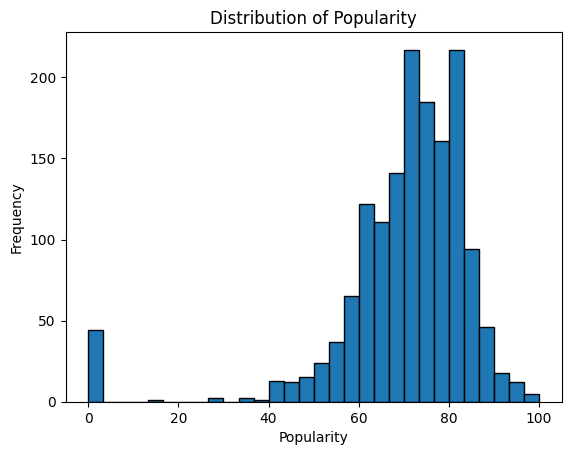

In [143]:
plt.hist((df['Popularity']), bins=30, edgecolor='black')
plt.title('Distribution of Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.show()

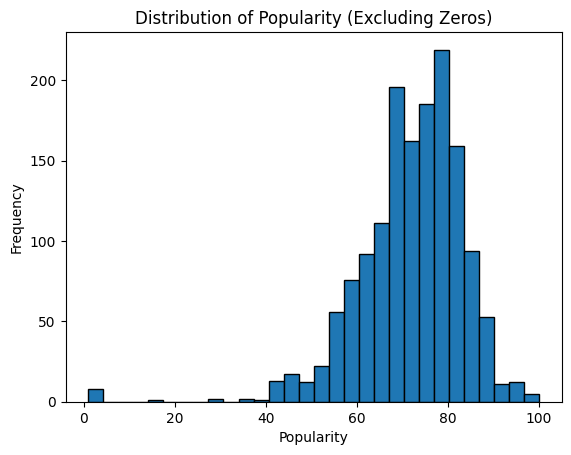

In [144]:
plt.hist(df[df['Popularity'] > 0]['Popularity'], bins=30, edgecolor='black')
plt.title('Distribution of Popularity (Excluding Zeros)')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.show()

In [145]:
# Median imputation
df['Popularity'] = df['Popularity'].replace(0, np.nan)
df['Popularity'] = df['Popularity'].fillna(df['Popularity'].median())

In [146]:
# See instances of '' again
(df.isna() | (df == '') | (df == 0)).sum()

,0
Highest Charting Position,0
Number of Times Charted,0
Streams,0
Artist Followers,0
Popularity,0
Danceability,0
Energy,0
Loudness,0
Speechiness,0
Acousticness,0


In [147]:
# Data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1555
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Highest Charting Position  1545 non-null   int64  
 1   Number of Times Charted    1545 non-null   int64  
 2   Streams                    1545 non-null   int64  
 3   Artist Followers           1545 non-null   int64  
 4   Popularity                 1545 non-null   float64
 5   Danceability               1545 non-null   float64
 6   Energy                     1545 non-null   float64
 7   Loudness                   1545 non-null   float64
 8   Speechiness                1545 non-null   float64
 9   Acousticness               1545 non-null   float64
 10  Liveness                   1545 non-null   float64
 11  Tempo                      1545 non-null   float64
 12  Duration (ms)              1545 non-null   float64
 13  Valence                    1545 non-null   float64
 1

In [148]:
df['Chord'] = df['Chord'].str.strip()

Data seems to be clean and ready to go!!!

- We converted dtypes
- Got rid of nulls, whitespaces, '', and 0's where applicable.
- Removed columns that are id's and also those too complex to deal with for now.
- Removed date columns. Future feature enginnering could be done with these in future versions.

## Exploratory Data Analysis


In [149]:
df.head()

,Highest Charting Position,Number of Times Charted,Streams,Artist Followers,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,8,48633449,3377762,100.0,0.714,0.800,-4.808,0.0504,0.1270,0.3590,134.002,211560.0,0.589,B
1,2,3,47248719,2230022,99.0,0.591,0.764,-5.484,0.0483,0.0383,0.1030,169.928,141806.0,0.478,C#/Db
2,1,11,40162559,6266514,99.0,0.563,0.664,-5.044,0.1540,0.3350,0.0849,166.928,178147.0,0.688,A
3,3,5,37799456,83293380,98.0,0.808,0.897,-3.712,0.0348,0.0469,0.3640,126.026,231041.0,0.591,B
4,5,1,33948454,5473565,96.0,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000.0,0.894,D#/Eb


In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1555
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Highest Charting Position  1545 non-null   int64  
 1   Number of Times Charted    1545 non-null   int64  
 2   Streams                    1545 non-null   int64  
 3   Artist Followers           1545 non-null   int64  
 4   Popularity                 1545 non-null   float64
 5   Danceability               1545 non-null   float64
 6   Energy                     1545 non-null   float64
 7   Loudness                   1545 non-null   float64
 8   Speechiness                1545 non-null   float64
 9   Acousticness               1545 non-null   float64
 10  Liveness                   1545 non-null   float64
 11  Tempo                      1545 non-null   float64
 12  Duration (ms)              1545 non-null   float64
 13  Valence                    1545 non-null   float64
 1

In [151]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Highest Charting Position,1545.0,8.782524e+01,5.813205e+01,1.000000e+00,3.700000e+01,8.000000e+01,1.370000e+02,2.000000e+02
Number of Times Charted,1545.0,1.068414e+01,1.638976e+01,1.000000e+00,1.000000e+00,4.000000e+00,1.200000e+01,1.420000e+02
Streams,1545.0,6.337136e+06,3.375402e+06,4.176083e+06,4.915080e+06,5.269163e+06,6.452492e+06,4.863345e+07
Artist Followers,1545.0,1.471690e+07,1.667579e+07,4.883000e+03,2.123734e+06,6.852509e+06,2.269875e+07,8.333778e+07
Popularity,1545.0,7.179029e+01,1.153958e+01,1.000000e+00,6.600000e+01,7.300000e+01,8.000000e+01,1.000000e+02
Danceability,1545.0,6.899968e-01,1.424440e-01,1.500000e-01,5.990000e-01,7.070000e-01,7.960000e-01,9.800000e-01
Energy,1545.0,6.334951e-01,1.615770e-01,5.400000e-02,5.320000e-01,6.420000e-01,7.520000e-01,9.700000e-01
Loudness,1545.0,-6.348474e+00,2.509281e+00,-2.516600e+01,-7.491000e+00,-5.990000e+00,-4.711000e+00,1.509000e+00
Speechiness,1545.0,1.236557e-01,1.103827e-01,2.320000e-02,4.560000e-02,7.650000e-02,1.650000e-01,8.840000e-01
Acousticness,1545.0,2.486945e-01,2.503259e-01,2.550000e-05,4.850000e-02,1.610000e-01,3.880000e-01,9.940000e-01


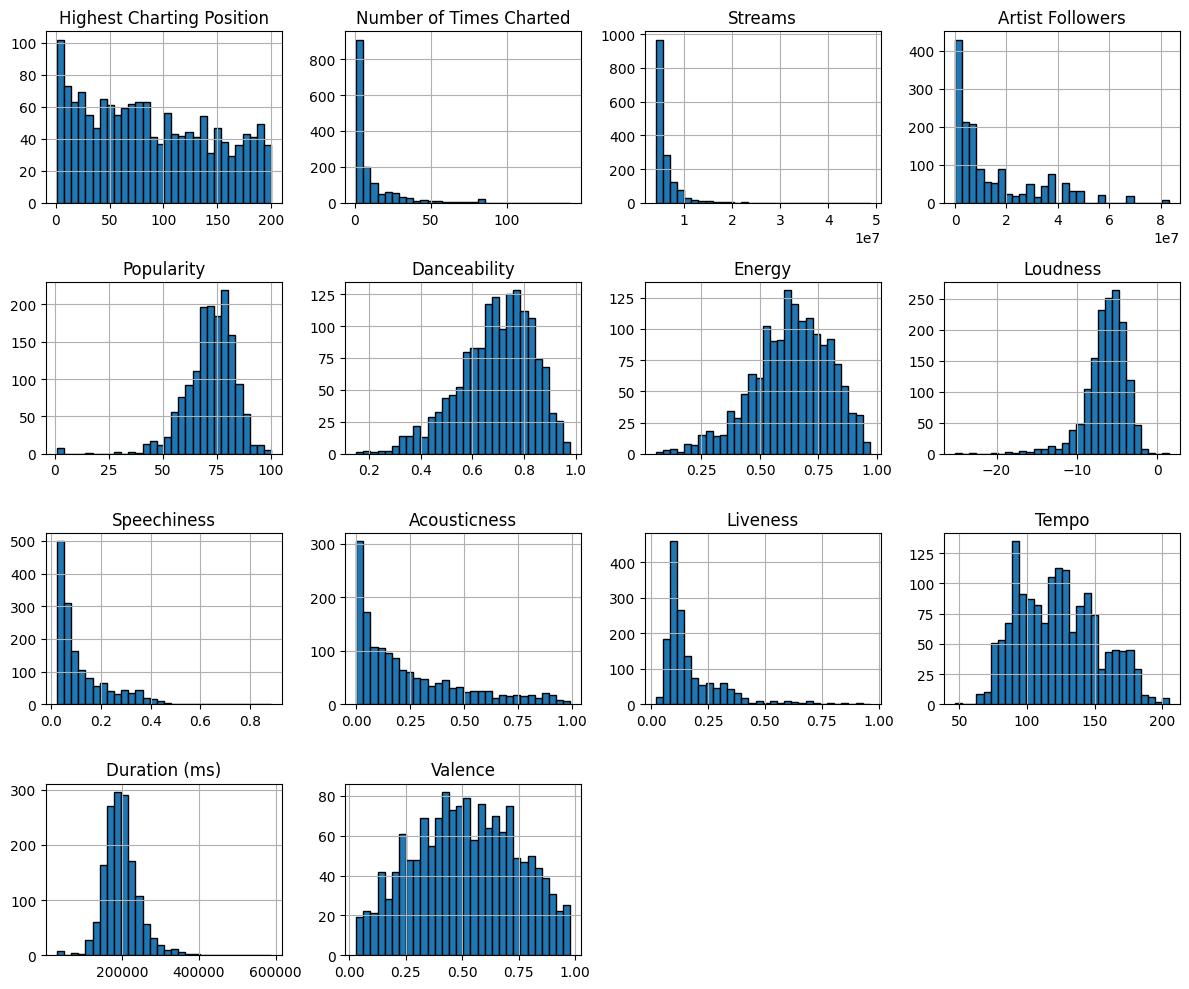

In [152]:
df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.tight_layout()
plt.show()

In [153]:
# Creating correlation
corr = df.corr(numeric_only=True).round(2)
corr

,Highest Charting Position,Number of Times Charted,Streams,Artist Followers,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence
Highest Charting Position,1.00,-0.42,-0.30,-0.23,-0.28,0.02,0.06,0.03,0.04,-0.01,0.01,0.03,-0.03,0.05
Number of Times Charted,-0.42,1.00,-0.06,0.03,0.39,0.03,-0.06,0.03,-0.06,0.05,-0.06,-0.05,0.03,0.02
Streams,-0.30,-0.06,1.00,0.10,0.14,-0.08,0.00,-0.03,-0.06,0.03,0.04,0.05,0.02,0.04
Artist Followers,-0.23,0.03,0.10,1.00,0.02,-0.10,-0.07,-0.03,-0.07,0.02,-0.01,-0.02,0.14,-0.11
Popularity,-0.28,0.39,0.14,0.02,1.00,0.04,0.11,0.20,-0.08,-0.10,-0.06,-0.04,0.07,0.03
Danceability,0.02,0.03,-0.08,-0.10,0.04,1.00,0.14,0.23,0.24,-0.32,-0.11,-0.04,-0.10,0.36
Energy,0.06,-0.06,0.00,-0.07,0.11,0.14,1.00,0.73,0.02,-0.54,0.12,0.11,0.06,0.36
Loudness,0.03,0.03,-0.03,-0.03,0.20,0.23,0.73,1.00,-0.02,-0.48,0.04,0.10,0.08,0.30
Speechiness,0.04,-0.06,-0.06,-0.07,-0.08,0.24,0.02,-0.02,1.00,-0.13,0.07,0.11,-0.09,0.04
Acousticness,-0.01,0.05,0.03,0.02,-0.10,-0.32,-0.54,-0.48,-0.13,1.00,-0.01,-0.06,-0.05,-0.10


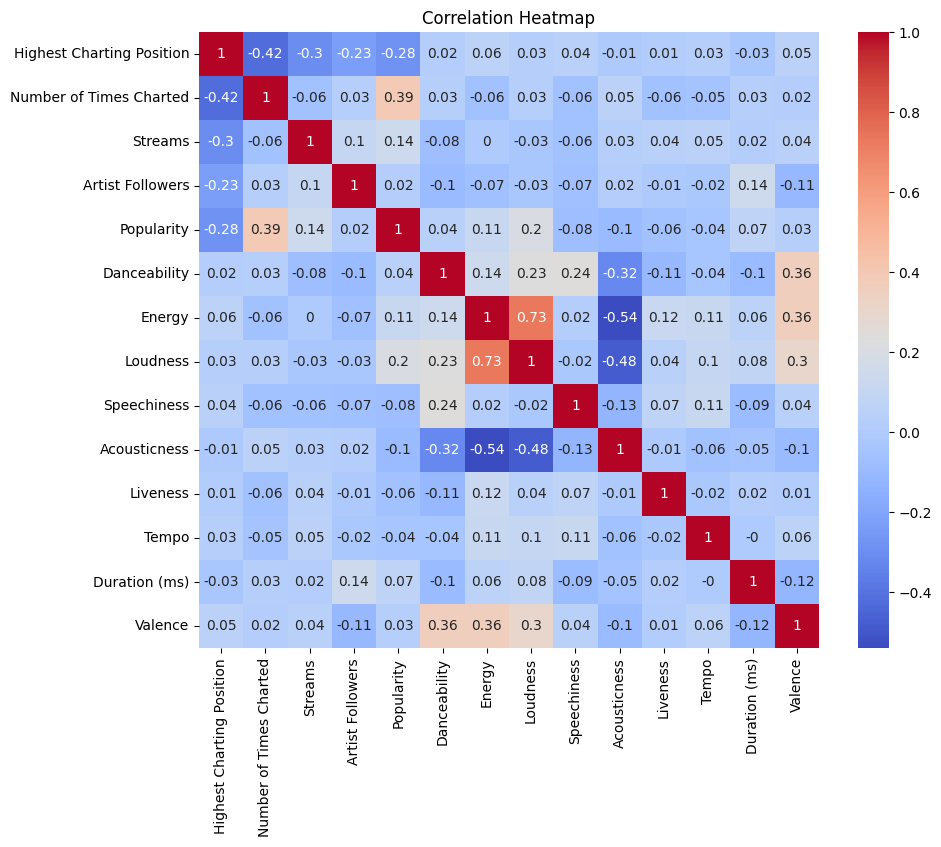

In [154]:
# Not Necessary. Just nice to see.
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Processing



In [155]:
df.columns

Index(['Highest Charting Position', 'Number of Times Charted', 'Streams',
       'Artist Followers', 'Popularity', 'Danceability', 'Energy', 'Loudness',
       'Speechiness', 'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)',
       'Valence', 'Chord'],
      dtype='object')

In [156]:
# Drop data leakage
df = df.drop(columns = ['Highest Charting Position', 'Streams'])

In [157]:
# Retrieve df pre encoding
df

,Number of Times Charted,Artist Followers,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,8,3377762,100.0,0.714,0.800,-4.808,0.0504,0.12700,0.3590,134.002,211560.0,0.589,B
1,3,2230022,99.0,0.591,0.764,-5.484,0.0483,0.03830,0.1030,169.928,141806.0,0.478,C#/Db
2,11,6266514,99.0,0.563,0.664,-5.044,0.1540,0.33500,0.0849,166.928,178147.0,0.688,A
3,5,83293380,98.0,0.808,0.897,-3.712,0.0348,0.04690,0.3640,126.026,231041.0,0.591,B
4,1,5473565,96.0,0.736,0.704,-7.409,0.0615,0.02030,0.0501,149.995,212000.0,0.894,D#/Eb
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,1,27167675,79.0,0.762,0.700,-6.021,0.0694,0.00261,0.1530,116.073,209320.0,0.608,A
1552,1,15019109,66.0,0.528,0.870,-3.123,0.0851,0.24000,0.3330,152.370,181930.0,0.714,B
1553,1,22698747,81.0,0.765,0.523,-4.333,0.0300,0.18400,0.1320,104.988,217307.0,0.394,D
1554,1,208630,60.0,0.832,0.550,-7.026,0.0587,0.24900,0.1820,154.064,152784.0,0.881,F


In [158]:
# One-hot encode 'Chord' column using get_dummies
df_encoded = pd.get_dummies(
    df,
    columns=['Chord'],
    drop_first=True,     # avoids redundant column
    prefix='Chord',      # optional: keeps column names clear
    prefix_sep='_'
)

# Replace original df
df_encoded

,Number of Times Charted,Artist Followers,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord_A#/Bb,Chord_B,Chord_C,Chord_C#/Db,Chord_D,Chord_D#/Eb,Chord_E,Chord_F,Chord_F#/Gb,Chord_G,Chord_G#/Ab
0,8,3377762,100.0,0.714,0.800,-4.808,0.0504,0.12700,0.3590,134.002,211560.0,0.589,False,True,False,False,False,False,False,False,False,False,False
1,3,2230022,99.0,0.591,0.764,-5.484,0.0483,0.03830,0.1030,169.928,141806.0,0.478,False,False,False,True,False,False,False,False,False,False,False
2,11,6266514,99.0,0.563,0.664,-5.044,0.1540,0.33500,0.0849,166.928,178147.0,0.688,False,False,False,False,False,False,False,False,False,False,False
3,5,83293380,98.0,0.808,0.897,-3.712,0.0348,0.04690,0.3640,126.026,231041.0,0.591,False,True,False,False,False,False,False,False,False,False,False
4,1,5473565,96.0,0.736,0.704,-7.409,0.0615,0.02030,0.0501,149.995,212000.0,0.894,False,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,1,27167675,79.0,0.762,0.700,-6.021,0.0694,0.00261,0.1530,116.073,209320.0,0.608,False,False,False,False,False,False,False,False,False,False,False
1552,1,15019109,66.0,0.528,0.870,-3.123,0.0851,0.24000,0.3330,152.370,181930.0,0.714,False,True,False,False,False,False,False,False,False,False,False
1553,1,22698747,81.0,0.765,0.523,-4.333,0.0300,0.18400,0.1320,104.988,217307.0,0.394,False,False,False,False,True,False,False,False,False,False,False
1554,1,208630,60.0,0.832,0.550,-7.026,0.0587,0.24900,0.1820,154.064,152784.0,0.881,False,False,False,False,False,False,False,True,False,False,False


In [159]:
# Import Necessary Libraries for Model

import sklearn
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error


In [160]:
# Split data into train and test sets
features = df_encoded.drop(columns = "Number of Times Charted")
target = df_encoded["Number of Times Charted"]


In [161]:
# Ensure split
features

,Artist Followers,Popularity,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord_A#/Bb,Chord_B,Chord_C,Chord_C#/Db,Chord_D,Chord_D#/Eb,Chord_E,Chord_F,Chord_F#/Gb,Chord_G,Chord_G#/Ab
0,3377762,100.0,0.714,0.800,-4.808,0.0504,0.12700,0.3590,134.002,211560.0,0.589,False,True,False,False,False,False,False,False,False,False,False
1,2230022,99.0,0.591,0.764,-5.484,0.0483,0.03830,0.1030,169.928,141806.0,0.478,False,False,False,True,False,False,False,False,False,False,False
2,6266514,99.0,0.563,0.664,-5.044,0.1540,0.33500,0.0849,166.928,178147.0,0.688,False,False,False,False,False,False,False,False,False,False,False
3,83293380,98.0,0.808,0.897,-3.712,0.0348,0.04690,0.3640,126.026,231041.0,0.591,False,True,False,False,False,False,False,False,False,False,False
4,5473565,96.0,0.736,0.704,-7.409,0.0615,0.02030,0.0501,149.995,212000.0,0.894,False,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,27167675,79.0,0.762,0.700,-6.021,0.0694,0.00261,0.1530,116.073,209320.0,0.608,False,False,False,False,False,False,False,False,False,False,False
1552,15019109,66.0,0.528,0.870,-3.123,0.0851,0.24000,0.3330,152.370,181930.0,0.714,False,True,False,False,False,False,False,False,False,False,False
1553,22698747,81.0,0.765,0.523,-4.333,0.0300,0.18400,0.1320,104.988,217307.0,0.394,False,False,False,False,True,False,False,False,False,False,False
1554,208630,60.0,0.832,0.550,-7.026,0.0587,0.24900,0.1820,154.064,152784.0,0.881,False,False,False,False,False,False,False,True,False,False,False


In [162]:
# Ensure split
target

,Number of Times Charted
0,8
1,3
2,11
3,5
4,1
...,...
1551,1
1552,1
1553,1
1554,1


#### Train / Fit / Predict

In [163]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2
)

In [164]:
# Fit the decision tree
model = DecisionTreeRegressor(max_depth = 3)
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3)

In [165]:
# Make predictions on the test set using the trained model
y_pred = model.predict(X_test)

In [166]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))


In [167]:
# Show RMSE
print(f"CV RMSE: {rmse:.2f}")


CV RMSE: 14.97


In [168]:
# 🌳 Decision Tree Regressor with Manual Cross-Validation
numLoops = 500
rms_error = np.zeros(numLoops)

for idx in range(0, numLoops):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=idx)
    model = DecisionTreeRegressor(max_depth=3)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))

# Compute and display average RMSE
mean_rmse = np.mean(rms_error)
print(f"Cross-Validated RMSE: {mean_rmse:.2f}")

Cross-Validated RMSE: 14.20


In [169]:
print(rms_error)

[12.52246468 15.29996648 14.01537673 14.4152162  13.29969286 12.67484136
 14.39140686 15.27383507 14.93328173 12.2605216  15.71031255 11.7531342
 13.10628169 13.26580739 13.02263318 13.72878836 11.28760517 12.53028413
 13.01462579 14.64309837 14.32244156 15.37547086 14.72036728 14.07853415
 15.18805183 12.54241221 15.76467966 14.4998964  13.0772593  12.07641234
 13.36036343 13.84160285 14.16459338 13.35392988 15.47089871 15.5418019
 14.8863327  11.55175691 12.82863241 12.5647603  13.5848004  15.60948603
 13.65223156 15.68315797 14.93712593 14.59851242 13.84971562 14.58219705
 15.87400539 12.24419514 14.70910424 14.90920516 14.26864329 14.25276091
 12.89573192 14.33877147 17.45252081 13.98485129 12.94038972 16.52131428
 15.60318053 15.46932042 13.20711987 13.12572176 11.11115408 16.19678748
 15.72721247 12.66078202 15.1109311  13.03271065 14.02076891 15.21634486
 15.61923805 14.0491899  15.29698615 12.15911605 15.66522257 14.29440577
 15.27936124 15.64559739 14.48346805 14.53790742 14.0

In [170]:
# Hyperparameter Tuning: Tree Depth
max_depths = [1,2,3,4,5,6,7,8,9,10]
rms_depth = np.zeros(len(max_depths))
std_depth = np.zeros(len(max_depths))

numLoops = 500

for n, depth in enumerate(max_depths):
  rms_error = np.zeros(numLoops)

  for idx in range(0, numLoops):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=idx)
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))

  rms_depth[n] = rms_error.mean()
  std_depth[n] = rms_error.std( ddof = 1 )

In [171]:
# Depths
pd.DataFrame( zip( max_depths, rms_depth, std_depth ) )

,0,1,2
0,1,14.527769,1.301386
1,2,14.310557,1.326453
2,3,14.243588,1.354959
3,4,14.486241,1.273357
4,5,15.267818,1.309206
5,6,16.136228,1.358519
6,7,16.857786,1.364698
7,8,17.458534,1.400359
8,9,17.955239,1.411936
9,10,18.319226,1.424012


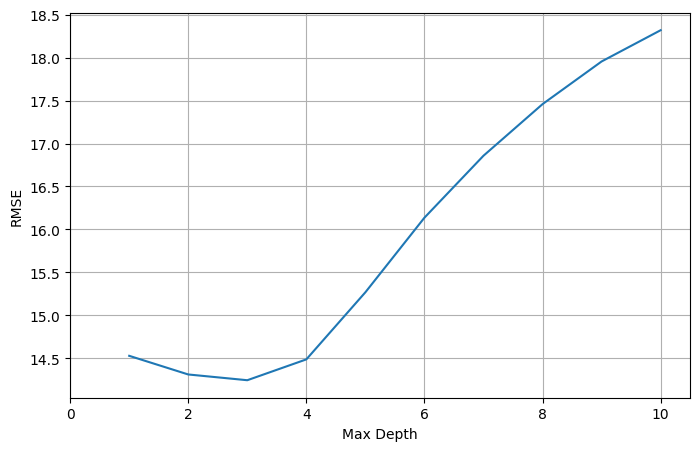

In [172]:
# Plot Depth Results
plt.figure(figsize = (8,5))
plt.plot(max_depths, rms_depth)
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.xlim(0, 10.5)
plt.grid()

In [173]:
df.columns

Index(['Number of Times Charted', 'Artist Followers', 'Popularity',
       'Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness',
       'Liveness', 'Tempo', 'Duration (ms)', 'Valence', 'Chord'],
      dtype='object')

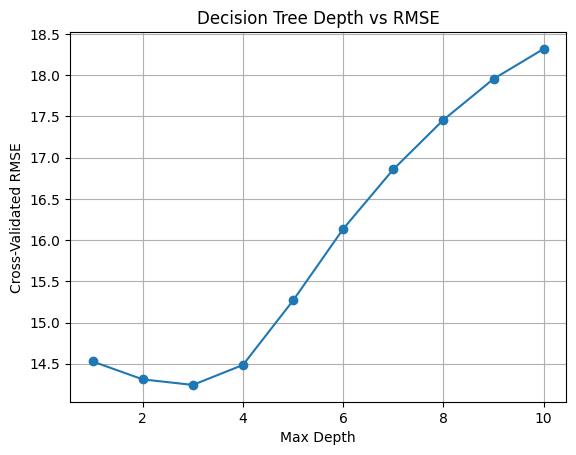

In [174]:
plt.errorbar(max_depths, rms_depth, fmt='-o')
plt.xlabel("Max Depth")
plt.ylabel("Cross-Validated RMSE")
plt.title("Decision Tree Depth vs RMSE")
plt.grid(True)

# ✅ Save before showing
plt.savefig("Optimal_Tree_Depth.png", dpi=300, bbox_inches='tight')
plt.show()

Finding the optimal tree depth is about balancing simplicity and accuracy. If the tree is too shallow, it becomes overly simple and fails to capture important relationships in the data, leading to underfitting. On the other hand, if the tree is too deep, it becomes overly complex and starts memorizing noise rather than learning meaningful patterns, causing overfitting. By tuning the tree’s depth, we identify the point where the model captures real relationships while still generalizing well to new, unseen data. In our case, a max tree depth of 3 was optimal in striking a balance between bias and variance.

In [175]:
# Re run with lowest depth (Cross Validation)
numLoops = 500
rms_error = np.zeros(numLoops)

for idx in range(0, numLoops):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=idx)
    model = DecisionTreeRegressor(max_depth=3)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))

# Compute and display average RMSE
mean_rmse = np.mean(rms_error)
print(f"Cross-Validated RMSE: {mean_rmse:.2f}")

Cross-Validated RMSE: 14.20


In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1555
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number of Times Charted  1545 non-null   int64  
 1   Artist Followers         1545 non-null   int64  
 2   Popularity               1545 non-null   float64
 3   Danceability             1545 non-null   float64
 4   Energy                   1545 non-null   float64
 5   Loudness                 1545 non-null   float64
 6   Speechiness              1545 non-null   float64
 7   Acousticness             1545 non-null   float64
 8   Liveness                 1545 non-null   float64
 9   Tempo                    1545 non-null   float64
 10  Duration (ms)            1545 non-null   float64
 11  Valence                  1545 non-null   float64
 12  Chord                    1545 non-null   object 
dtypes: float64(10), int64(2), object(1)
memory usage: 169.0+ KB


## Data Visualization/Communication of Results


For this project, I decided to use “Number of Times Charted” as the target variable instead of Spotify’s built-in popularity score. The built-in popularity metric is a snapshot value that reflects Spotify’s internal score based on stream counts, recency, and other factors at a single point in time. In contrast, “Number of Times Charted” better captures a song’s consistency and longevity — for example, a song that appears on the Top 200 for 20 weeks demonstrates sustained popularity, whereas a song that charts for only one week may have short-term success.

After cleaning and refining the dataset, I went from 1,556 rows to 1,545 and reduced the number of columns from 23 to 13 (before applying one-hot encoding). I chose to drop date-related columns since they weren’t directly useful in this model, though they could later be used for feature engineering — such as extracting the release month to see if songs released in certain seasons (like summer) perform better. I also dropped the genre column because it contained lists of multiple genres per song, but techniques like binning or multi-label encoding could be explored in future iterations. Additionally, I removed identifier columns that don’t contribute predictive value, and converted the remaining features to their proper data types to ensure accuracy in modeling.

A Decision Tree Regressor was trained to predict song popularity using Spotify’s Top 200 Weekly data. The model was tested across 500 randomized train-test splits using different tree depths to find the best balance between bias and variance. Results showed that a max depth of 3 produced the lowest cross-validated RMSE of 14.22, indicating it was the most accurate and stable model. Shallower trees (depth 1–2) underfit the data, while deeper trees (depth 4 and above) slightly overfit, increasing error without improving predictions.

The next steps could involve normalizing or transforming the target variable (such as with a log transform) to stabilize variance and potentially improve regression performance. Future work may also include testing additional hyperparameters or trying ensemble methods like Random Forest or Gradient Boosting (XGB) to further lower the RMSE. Even selecting the popularity feature as a target is an optimal choice!

Additionally, exploring feature importance techniques could provide valuable insight into which variables most influence the model’s predictions. This approach is especially useful in tree-based models since they don’t use coefficients/ like linear models do. Instead, feature importance measures how much each feature reduces prediction error (MSE) across all splits in the tree. However, this method was not implemented in this iteration because it conflicted with my one-hot encoded features and removed them during processing.

In [177]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

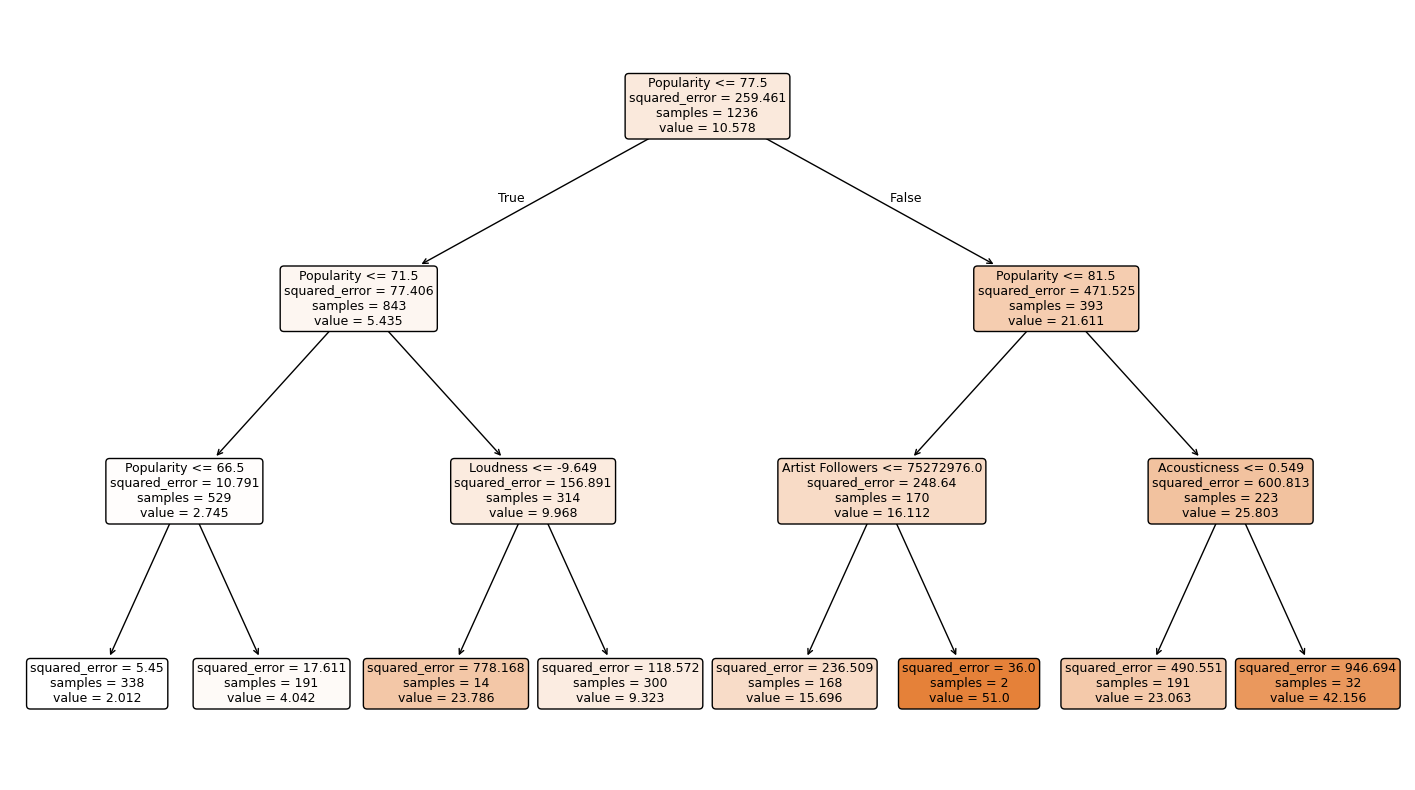

In [178]:
plt.figure(figsize=(18,10))
plot_tree(model, feature_names=X_train.columns, filled=True, rounded=True, fontsize=9)

# ✅ Save before showing
plt.savefig("Decision_Tree.png", dpi=300, bbox_inches='tight')
plt.show()

The decision tree reveals that popularity is the strongest predictor of how long a song remains on the Spotify Top 200 charts. For less popular songs (popularity ≤ 77.5), Loudness eventully plays a role.. For more popular songs (popularity > 77.5), acousticness and artist followers play a role further alonth the descion tree.

## Notes for me... Top secret, do not read.

🎯 **Bias and Variance: The Trade-Off**

Machine learning models make prediction errors for two main reasons:
bias (being too simple) and variance (being too sensitive).

Type	Description	What It Looks Like
Bias	Error from making overly simple assumptions about the data. The model misses real patterns.	Predictions are too smooth or always near the average.
Variance	Error from being too complex and reacting too strongly to small details in the training data. The model memorizes noise.	Predictions fit the training set perfectly but fail on new data.

⚙️ **How it applies to your tree depths**

Shallow trees (depth 1–2) → High bias, low variance

Too simple — they can’t capture all the patterns in the features.

They generalize well but miss important structure → underfitting.

Deep trees (depth 4+) → Low bias, high variance

Too detailed — they memorize the training data’s quirks.

They perform great on training data but worse on unseen data → overfitting.

Depth = 3 → Balanced bias and variance

The tree is complex enough to learn key relationships but still generalizes well.

That’s why you saw the lowest RMSE at this point.


**In decision trees (and most models):**

High bias → happens when the tree is too shallow.

The model is too simple, misses real patterns → underfitting.

High variance → happens when the tree is too deep.

The model learns tiny details and noise in the training data → overfitting.

So yes — in your case:

Shallow tree = high bias,
Deep tree = high variance.


**This info is not for the decsion tree visualized above:**

The decision tree reveals that popularity is the strongest predictor of how long a song remains on the Spotify Top 200 charts. For less popular songs (popularity ≤ 76.5), chart performance and artist following play major roles — smaller artists with early, high chart positions tend to remain on the charts longer, while others with lower initial rankings tend to drop off quickly. For more popular songs (popularity > 76.5), chart position becomes the key determinant of longevity, as tracks that peak within the top 50 typically stay on the charts far longer than those debuting at lower ranks. Overall, the model highlights how a combination of highest chart success, artist reach, and song popularity work together to explain a song’s long-term chart presence.

**Explaining Node Splits:**

squared_error:
The mean squared error (MSE) within that node — it shows how much the actual target values (e.g., “number of times charted”) vary around the predicted mean. Lower = better fit (more consistent predictions).

samples: How many data points (songs) ended up in that node after all splits.

value: The predicted mean target value for all songs in that node — this is the model’s prediction for that group.

***Artist Followers Example (Lower Left):***

Think of squared_error at a node as measuring how mixed the target values are before and after splitting.

**At the split node**

- squared_error = 494.83 means that before the split, songs in this group (39 total) had a fairly wide range of “number of times charted.”

- The model sees that dividing by Artist Followers (≤ 3.4M) helps reduce that variation.

**At the two leaf nodes below**

- squared_error = 815.585 (left leaf, 17 songs): This group still has quite a bit of variation — some songs charted for many more weeks than others, even within this smaller set.

- squared_error = 54.498 (right leaf, 22 songs): This group is much purer — those songs all had roughly similar chart durations (around 11 weeks).

**What this tells you:**

- The parent node (494.83) had mixed outcomes.

- Splitting by artist followers reduced that mix overall.

- But one child group (≤ 3.4M followers) still had high internal variance — probably because some small artists unexpectedly charted for many weeks.

- The other child group (> 3.4M followers) was more consistent — most of those artists’ songs performed similarly.